# **Table of Content**

**Regression**:

[Problem we are trying to solve](#section-a1)

[Check data type and visualize data](#section-a2)

[Data Exploratory using Clustering](#section-a3)

[Select Optimal Features](#section-a4)

[Reduce Data Dimension](#section-a5)

[Algorithm - Decision Tree (Regression)](#section-a6)

[Algorithm - Linear Regression](#section-a7)

[Algorithm - KNN (Regression)](#section-a8)

[Algorithm - Random Forest (Regression)](#section-a9)

[Conclusion and Findings](#section-a10)



**Classification**:

[Problem we are trying to solve](#section-b1)

[Check data type and visualize data](#section-b2)

[Data Exploratory using Clustering](#section-b3)

[Select Optimal Features](#section-b4)

[Reduce Data Dimension](#section-b5)

[Algorithm - Decision Tree (Classification)](#section-b6)

[Algorithm - KNN (Classification)](#section-b7)

[Algorithm - Logistic Regression](#section-b8)

[Algorithm - Random Forest (Classification)](#section-b9)

[Conclusion and Findings](#section-b10)

# **Regression**

<a name="section-a1"></a> **Problem: Determine the best algorithm that accurately predict the percetage of hospitalized patient with COVID given data (features such as previous day COVID admission, hospital beds used, etc).**



---



**Check data type and visualize data** <a name="section-a2"></a>

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics, datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import decomposition

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 30)
pd.set_option('display.width', 10000)

data = pd.read_csv('/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State.csv')

print(data.info())
print(data.describe())
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Columns: 134 entries, state to total_staffed_pediatric_icu_beds_coverage
dtypes: float64(41), int64(92), object(1)
memory usage: 56.7+ KB
None
       critical_staffing_shortage_today_yes  critical_staffing_shortage_today_no  critical_staffing_shortage_today_not_reported  critical_staffing_shortage_anticipated_within_week_yes  critical_staffing_shortage_anticipated_within_week_no  ...  staffed_icu_pediatric_patients_confirmed_covid_coverage  staffed_pediatric_icu_bed_occupancy  staffed_pediatric_icu_bed_occupancy_coverage  total_staffed_pediatric_icu_beds  total_staffed_pediatric_icu_beds_coverage
count                             54.000000                            54.000000                                      54.000000                                          54.000000                                               54.000000      ...                                          54.000000                                



---



**Data Exploratory using Clustering**:<a name="section-a3"></a>

After data visualization, do some data exloration using Hierarchical Clustering using states as labels and see if we can spot any patterns

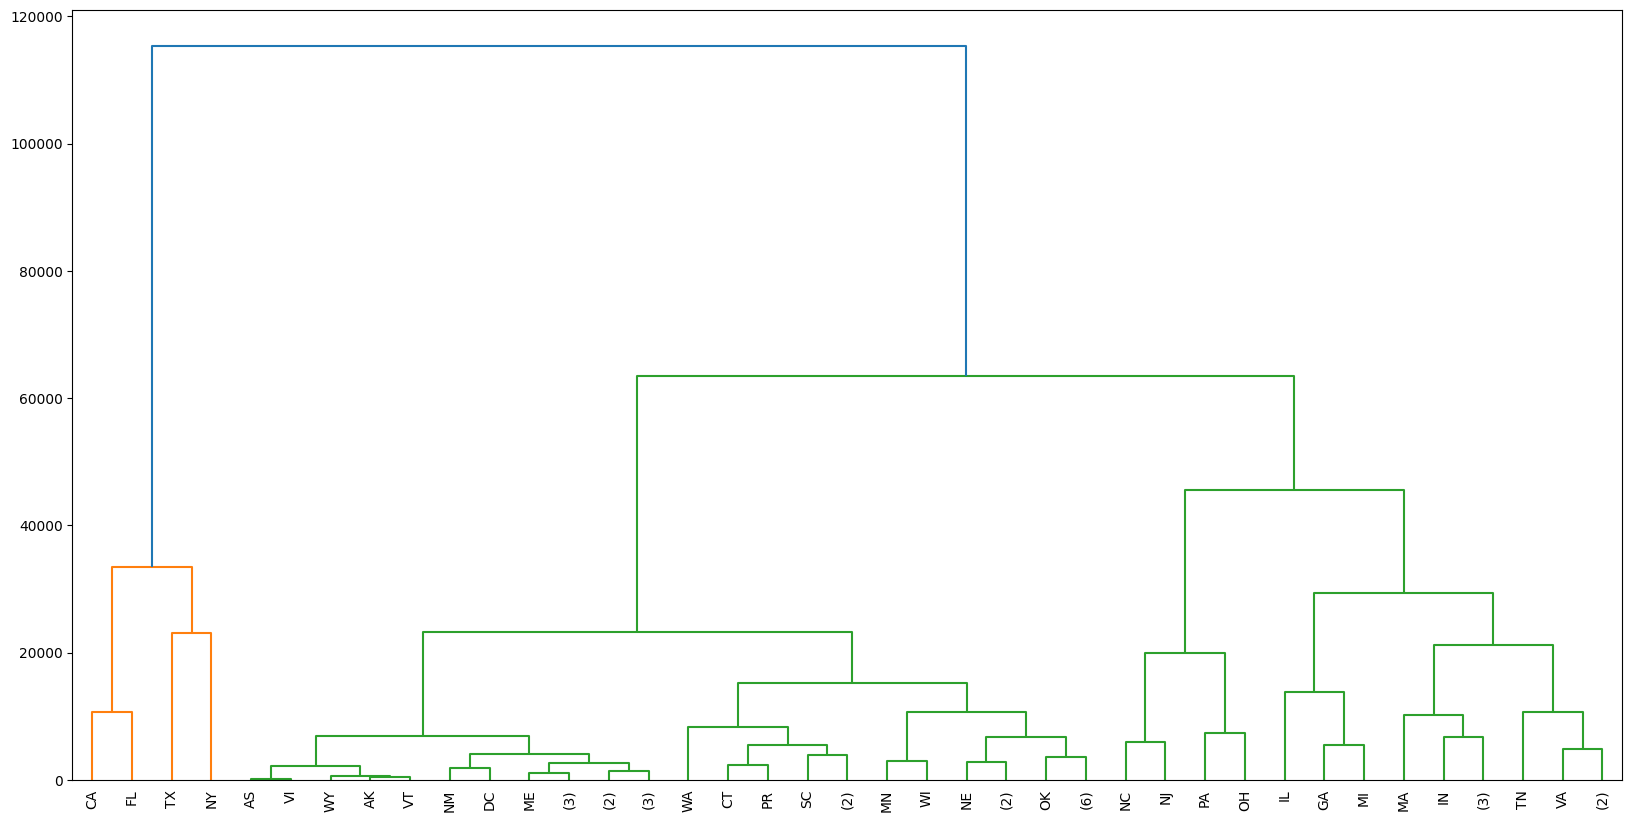

In [7]:
state = list(data['state'])

data = data.iloc[: , 1:]
data = data.fillna(0)

mergings = linkage(data, method='complete')

plt.figure(figsize=(20, 10))

dendrogram(mergings,
           p = 6,
           truncate_mode = 'level',
           labels = state,
leaf_rotation=90,
leaf_font_size=10,
)

plt.show()

**Conclusion from clustering:** States like CA and FL, and TX and NY appears to be similar to each other in terms of Covid hospitalization.

Others states that are similar includes AS and VI, AK and VT



---



**Select Optimal Features**<a name="section-a4"></a>

Given we have 49 features, and given the target variable is percentage of hospitalized patient with COVID in each state, we want to find number of optimal features out of all 49 features

Since feature selection for LogReg only work with discrete dataset, we want to apply discretization to our target variable first





In [ ]:
# discretization of the target variable
y = data['percent_of_inpatients_with_covid'] * 100
y_discrete = np.digitize(y,[0,1,2,3,4,5,6,7,8,9,10])

# drop the target feature and select the first 49 columns
data = data.drop(columns=['percent_of_inpatients_with_covid'])
X = data.iloc[: , 0:49]

logit=LogisticRegression(multi_class='ovr',solver='liblinear', max_iter=1000)

rfecv = RFECV(estimator=logit, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, y_discrete)

print(f"Optimal number of features : {rfecv.n_features_}")
print("Features rankings:", rfecv.ranking_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Optimal number of features : 40
Features rankings: [ 1  1  1  1  1  1  1  1  2  6  1  7  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  5  3  4  1  1  9 10  1  1
  8]


**Optimal feature selection conclusion**: According to the print statements above, 40 out of 49 features are optimal.



---



**Reduce Data Dimension:**<a name="section-a5"></a>

Now that we know the optimal number of features is 40 out of 49 features, reduce dimension to n = 40

In [ ]:
print("Shape of the original data set",X.shape)

pca = decomposition.PCA(n_components=40)
pca.fit(X)
X_reduced = pca.transform(X)
print("Shape of the new data set",X_reduced.shape)

print(X)


Shape of the original data set (54, 49)
Shape of the new data set (54, 40)
    critical_staffing_shortage_today_yes  critical_staffing_shortage_today_no  critical_staffing_shortage_today_not_reported  critical_staffing_shortage_anticipated_within_week_yes  critical_staffing_shortage_anticipated_within_week_no  ...  percent_of_inpatients_with_covid_denominator  inpatient_bed_covid_utilization  inpatient_bed_covid_utilization_coverage  inpatient_bed_covid_utilization_numerator  inpatient_bed_covid_utilization_denominator
0                                      1                                    6                                             11                                                  1                                                      15      ...                                         592.0                         0.016993                                      10.0                                       13.0                                        765.0
1                        



---



**Apply all regression methods for both original features and reduced features, and compare the result**

**Decision Tree (regression)**<a name="section-a6"></a>

Apply decision tree (regerssion) on both the original X and reduced X and compare error rates

In [ ]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=5)

clf = tree.DecisionTreeRegressor()

print("X original")
print("-------------------")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("y prediction: ", y_pred)
print("y actual: ", list(y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("\nX reduced")
print("-------------------")
clf.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print("y prediction: ", y_pred2)
print("y actual: ", list(y_test2))
print("X_reduced MAE: ", metrics.mean_absolute_error(y_test2, y_pred2))
print("X_reduced MSE: ", metrics.mean_squared_error(y_test2, y_pred2))
print("X_reduced RMSE: ", np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))


X original
-------------------
y prediction:  [1.4046823 1.8046358 0.6547836 0.        0.8207934 3.1965668 1.2970169
 0.        0.6036217 3.1350196 0.8207934 0.6036217 0.5802708 2.1661932]
y actual:  [1.4458134, 1.7132505, 0.9060023, 0.4056795, 0.8974359, 2.5734097, 1.0485197, 0.27777779999999996, 0.650524, 4.0931546, 0.9345794, 0.9225092, 0.7972857999999999, 2.1671827]
MAE:  0.2622288928571429
MSE:  0.13234253041559793
RMSE:  0.3637891290508801

X_reduced
-------------------
y prediction:  [0.78125   3.1350196 2.1959459 2.1959459 0.280112  1.2263158 4.1076115
 1.2263158 3.1845799 0.78125   9.9337748 1.3842746 1.7132505 1.2263158]
y actual:  [0.0, 0.8207934, 1.0282776, 0.8849558000000001, 0.4056795, 2.3842149, 1.4458134, 1.1491301, 2.6527649, 1.5594542, 2.5734097, 2.5955804999999996, 1.2970169, 0.650524]
X_reduced MAE:  1.4621643285714285
X_reduced MSE:  5.323658215370439
X_reduced RMSE:  2.3073054014088465


**Decision Tree Conclusion**: X original (MSE: 0.1323) performs better than X reduced (MSE: 5.3237) for decision tree





---



**Linear Regression**<a name="section-a7"></a>

Apply linear regerssion on both the original X and reduced X and compare error rates

In [ ]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=54)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=29)

#print(X_train)
#X_train = X_train.values.reshape(-1, 1)

print("X original")
print("-------------------")
regr.fit(X_train, y_train)
#print('Coefficients: \n', regr.coef_)
#print('Intercept: \n', regr.intercept_)
y_pred = regr.predict(X_test)
print("y prediction: ", y_pred)
print("y actual:", list(y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("\nX reduced")
print("-------------------")
regr.fit(X_train2, y_train2)
#print('Coefficients: \n', regr.coef_)
#print('Intercept: \n', regr.intercept_)
y_pred2 = regr.predict(X_test2)
print("y prediction: ", y_pred2)
print("y actual:", list(y_test2))
print("X_reduced MAE: ", metrics.mean_absolute_error(y_test2, y_pred2))
print("X_reduced MSE: ", metrics.mean_squared_error(y_test2, y_pred2))
print("X_reduced RMSE: ", np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))

X original
-------------------
y prediction:  [ 1.47977677 -5.11671021  0.58461891  1.69356697  3.79253299  0.88606438
  0.82722214  1.57186861  1.13886408  0.48451727 -0.09902136  3.40747696
  0.70959366 -0.82098398]
y actual [1.4046823, 2.3842149, 1.4458134, 3.1845799, 0.8207934, 0.27777779999999996, 0.9225092, 1.5238095, 1.0485197, 0.8849558000000001, 0.0, 2.4814976, 0.6036217, 0.78125]
MAE:  1.2053992078463491
MSE:  5.147219292808846
RMSE:  2.268748397863643

X reduced
-------------------
y prediction:  [2.53608512e+00 2.22671295e+00 9.25461383e+07 2.00594940e+00
 1.03273241e+00 1.28518780e+00 3.66085730e+00 8.35181165e-01
 9.64648742e-01 5.25546729e-01 1.36883373e+00 4.88298025e+00
 2.25242901e+00 2.14032262e+00]
y actual [2.3424879, 1.2263158, 0.0, 0.650524, 1.4764008, 0.0, 2.4671735, 0.9060023, 1.0282776, 0.78125, 1.3096098, 3.1965668000000003, 1.0638298, 3.1845799]
X_reduced MAE:  6610439.149971054
X_reduced MSE:  611770550475122.1
X_reduced RMSE:  24733995.845296048


**Linear Regression Conclusion**: X original (MSE: 5.14) performs much better than X reduced (MSE: very large) for linear regression as X original MSE error rate is much lower. Linear regression in general perform worst than decision tree



---



**KNN (regression)**<a name="section-a8"></a>

Apply KNN on both the original X and reduced X and compare error rates. Find error rate for K between 1 to 20 to see which one performs the best

In [ ]:
from sklearn import neighbors

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=9)

#rmse_val = [] #to store rmse values for different k
print("X original")
print("-------------------")
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    y_pred=model.predict(X_test) #make prediction on test set
    error = metrics.mean_squared_error(y_test, y_pred) #calculate rmse
    #rmse_val.append(error) #store rmse values
    print('MSE value for k= ' , K , 'is:', error)

print("\nX reduced")
print("-------------------")
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train2, y_train2)  #fit the model
    y_pred2=model.predict(X_test2) #make prediction on test set
    error = metrics.mean_squared_error(y_test2, y_pred2) #calculate rmse
    #rmse_val.append(error) #store rmse values
    print('X_reduced MSE value for k= ' , K , 'is:', error)


X original
-------------------
MSE value for k=  1 is: 7.887403794204283
MSE value for k=  2 is: 6.142704717334602
MSE value for k=  3 is: 5.726131413014052
MSE value for k=  4 is: 5.729782561528443
MSE value for k=  5 is: 5.686724674366024
MSE value for k=  6 is: 5.545855019724544
MSE value for k=  7 is: 5.637963710662381
MSE value for k=  8 is: 5.604338330176371
MSE value for k=  9 is: 5.701514773253135
MSE value for k=  10 is: 5.602002482738833
MSE value for k=  11 is: 5.753047724203708
MSE value for k=  12 is: 5.823654003833712
MSE value for k=  13 is: 5.965731335588771
MSE value for k=  14 is: 6.11642768424984
MSE value for k=  15 is: 6.187884605127481
MSE value for k=  16 is: 6.122423203025634
MSE value for k=  17 is: 6.0708579478704925
MSE value for k=  18 is: 6.058121843537757
MSE value for k=  19 is: 6.117670317831227
MSE value for k=  20 is: 6.20081954153935

X reduced
-------------------
X_reduced MSE value for k=  1 is: 1.8856960446440336
X_reduced MSE value for k=  2 is: 1

**KNN Conclusion**: X reduced performs better than X original in general for KNN as the error rate for X reduced is lower.

For X original: K = 6 is the best option (MSE: 5.55)

For X rediced: K = 18 is the best option (MSE: 0.91)

KNN performed better than linear regression but worst than decision tree



---



**Random Forest (regression)**<a name="section-a9"></a>

Apply Random Forest on both the original X and reduced X and compare error rates.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=12)

print("X original")
print("-------------------")
rfc = RandomForestRegressor(n_estimators=600)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
# print MAE. MSE, and RMSE
print("y prediction: ", y_pred)
print("y actual: ", list(y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("\nX reduced")
print("-------------------")
rfc = RandomForestRegressor(n_estimators=600)
rfc.fit(X_train2,y_train2)
y_pred2 = rfc.predict(X_test2)
# print MAE. MSE, and RMSE for X_reduced
print("y prediction: ", y_pred)
print("y actual: ", list(y_test))
print("X_reduced MAE: ", metrics.mean_absolute_error(y_test2, y_pred2))
print("X_reduced MSE: ", metrics.mean_squared_error(y_test2, y_pred2))
print("X_reduced RMSE: ", np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))

X original
-------------------
y prediction:  [0.37976312 1.52120928 1.30881701 1.52940619 2.30780549 2.56373217
 1.10690158 3.2641008  0.5337374  0.08533147 2.55634727 0.92396997
 1.50797343 1.42403152]
y actual:  [0.28011199999999997, 1.8046357999999998, 0.0, 1.9571295, 1.4764008, 2.1671827, 1.0282776, 2.5734097, 0.27777779999999996, 0.0, 2.1661932, 0.8207934, 0.8849558000000001, 1.5555002]
MAE:  0.40757108673809495
MSE:  0.2827877604933337
RMSE:  0.5317779240372185

X reduced
-------------------
y prediction:  [0.37976312 1.52120928 1.30881701 1.52940619 2.30780549 2.56373217
 1.10690158 3.2641008  0.5337374  0.08533147 2.55634727 0.92396997
 1.50797343 1.42403152]
y actual:  [0.28011199999999997, 1.8046357999999998, 0.0, 1.9571295, 1.4764008, 2.1671827, 1.0282776, 2.5734097, 0.27777779999999996, 0.0, 2.1661932, 0.8207934, 0.8849558000000001, 1.5555002]
X_reduced MAE:  1.22535963313095
X_reduced MSE:  2.683669514450389
X_reduced RMSE:  1.6381909273495532


**Random forest Conclusion**: X original (MSE: 0.2828) performs better than X reduced (MSE: 2.6837) for random forest.



---



**All regression methods conclusion:** <a name="section-a10"></a>

Regression algorithms for the selected data ranked from best to worst according to the conclusions above:

*   **X original:**
Decision Tree (MSE: 0.1323) > Random Forest (MSE: 0.2828) > Linear Regression (MSE: 5.14) > KNN (MSE: 5.55)
*   **X reduced:**
KNN (MSE: 0.91) > Random Forest (MSE: 2.6837) > Decision Tree (MSE: 5.3237) > Linear Regression (MSE: very large)

**Findings:**
For X original, Decision Tree and Random Forest seems to perform very well while Linear Regression and KNN performed poorly. This makes sense as there are some outliers in the data (ex: some state has abnormally high staff shortage in hospital) and Decision Tree and Random Forest are not sensetive to outliers.



---



# **Classification**

<a name="section-b1"></a>**Problem: Determine the best algorithm that accurately predict if an insurance claim for an individual is santioned or not  (based on features such as insurance agency name, agency net sales, insurance plan of the individual etc).**

<a name="section-b2"></a>**Check data type and visualize data**

In [5]:
data2 = pd.read_csv('/insurance_dataset.csv')

agency = list(data2["Agency"].iloc[:100])
# fill NaN fields with 0
data2 = data2.fillna(0)
data2 = data2.drop(columns=['Gender'])


print(data2.info())
print(data2.describe())
print(data2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10537 entries, 0 to 10536
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10537 non-null  int64  
 1   Age                   10537 non-null  int64  
 2   Agency                10537 non-null  object 
 3   Agency Type           10537 non-null  object 
 4   Commision (in value)  10537 non-null  float64
 5   Destination           10537 non-null  object 
 6   Distribution Channel  10537 non-null  object 
 7   Duration              10537 non-null  int64  
 8   Net Sales             10537 non-null  float64
 9   Product Name          10537 non-null  object 
 10  Claim                 10537 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 905.6+ KB
None
                 ID           Age  Commision (in value)      Duration     Net Sales         Claim
count  10537.000000  10537.000000          10537.000000  1053



---



<a name="section-b3"></a>**Data Exploratory using Clustering**:

After data visualization, do some data exloration using Hierarchical Clustering and agency name as labels and see if we can spot any patterns.

Hierarchical Clustering only work with numeric data, so apply LabelEncoder() to transform categorical data to numeric.

          ID  Age  Agency  Agency Type  Commision (in value)  ...  Distribution Channel  Duration  Net Sales  Product Name  Claim
0      45341   28       2            0                 28.13  ...                     1        34      112.5            17      1
1      12958   37       9            0                 12.95  ...                     1        53       37.0             8      0
2      18233   27       7            1                  0.00  ...                     1        28       13.0            10      0
3      31742   36       7            1                  0.00  ...                     1         1       34.0            10      0
4      14381   26       6            1                 23.76  ...                     1        33       39.6            16      0
...      ...  ...     ...          ...                   ...  ...                   ...       ...        ...           ...    ...
10532   9441   36       7            1                  0.00  ...                     1   

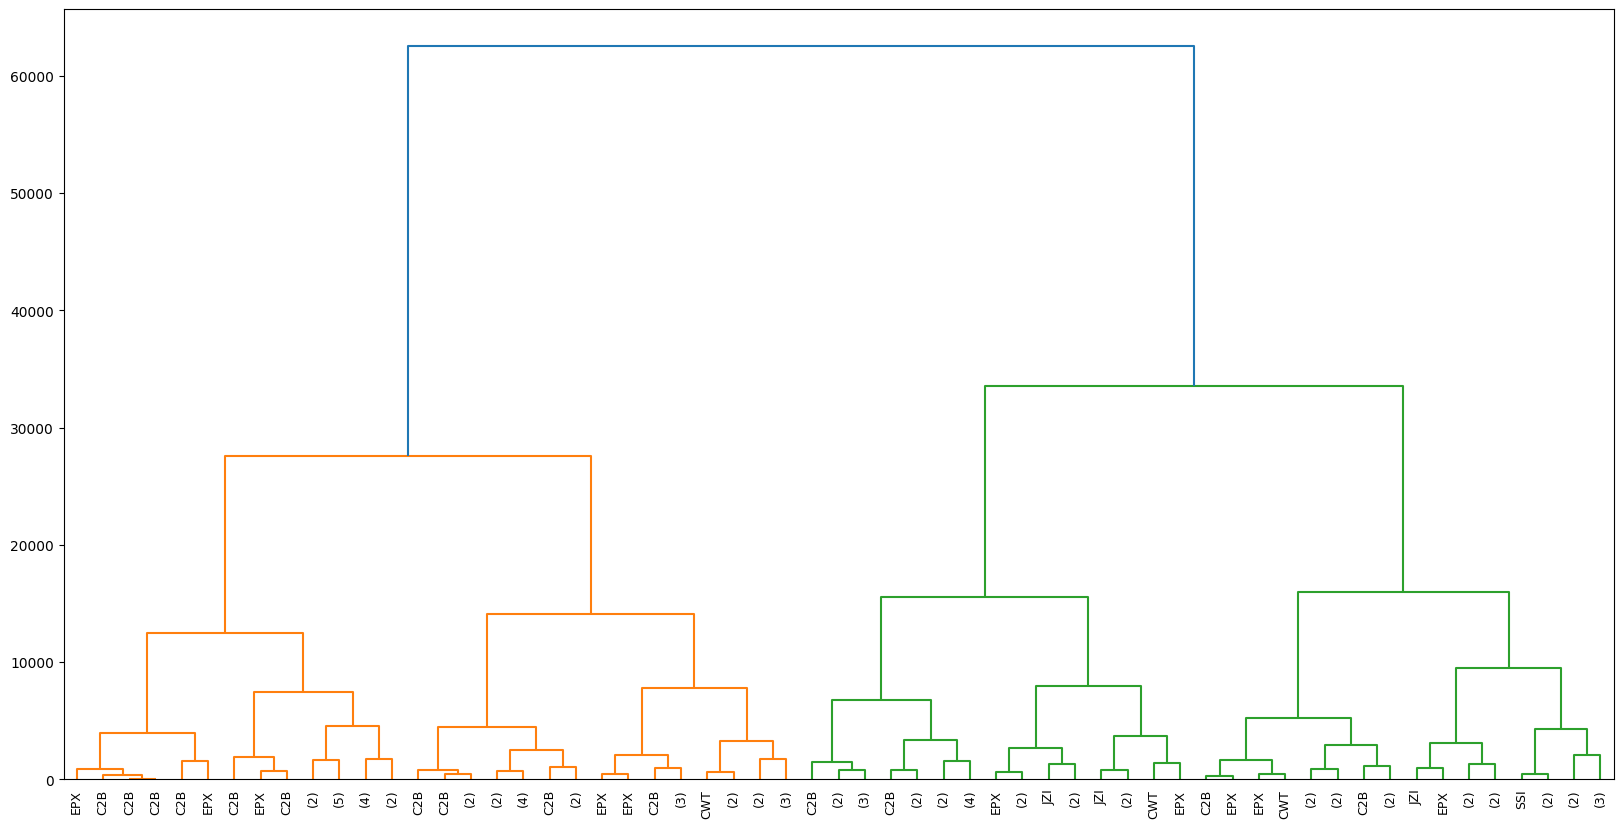

In [11]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

data2['Agency'] = label_encoder.fit_transform(data2['Agency'])
data2['Agency Type'] = label_encoder.fit_transform(data2['Agency Type'])
data2['Destination'] = label_encoder.fit_transform(data2['Destination'])
data2['Distribution Channel'] = label_encoder.fit_transform(data2['Distribution Channel'])
data2['Product Name'] = label_encoder.fit_transform(data2['Product Name'])



print(data2)
mergings = linkage(data2.head(100), method='complete')
plt.figure(figsize=(20, 10))

dendrogram(mergings,
           p = 5,
           truncate_mode = 'level',
           labels = agency,
leaf_rotation=90,
leaf_font_size=9,
)

plt.show()



**Conclusion from clustering:** claim submission for agency C2B is similar to other C2B submissions(which make sense). On top of that, it seems data for C2B claim submission is also similar to EPX submission as they are grouped closely in several instance (small distance between them compare to other agencies)



---



<a name="section-b4"></a>**Select Optimal Features**

Given we have 10 features, and given the target variable is whether the claim submissions are sanctioned or not (1 = sanctioned, 0 = not sanctioned), we want to find number of optimal features out of all 10 features.

In [12]:
X = data2.drop(columns=['Claim'])
y = data2['Claim']

logit=LogisticRegression(multi_class='ovr',solver='liblinear', max_iter=1000)

rfecv = RFECV(estimator=logit, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, y)

print(f"Optimal number of features : {rfecv.n_features_}")
print("listing column names and their ranking")
print(list(X.columns.values))
print(rfecv.ranking_)
#print(X.columns[0], X.columns[1],X.columns[30],X.columns[33], X.columns[37])


Optimal number of features : 9
listing column names and their ranking
['ID', 'Age', 'Agency', 'Agency Type', 'Commision (in value)', 'Destination', 'Distribution Channel', 'Duration', 'Net Sales', 'Product Name']
[2 1 1 1 1 1 1 1 1 1]


**Optimal feature selection conclusion**: According to the print statements above, besides feature "ID", every other feature is optimal



---



<a name="section-b5"></a>**Reduce Data Dimension:**

Now that we know the optimal number of features is 9 out of 10 features, reduce dimension to n = 9

In [14]:
print("Shape of the original data set",X.shape)

pca = decomposition.PCA(n_components=9)
pca.fit(X)
X_reduced = pca.transform(X)
print("Shape of the new data set",X_reduced.shape)

print(X_reduced)


Shape of the original data set (10537, 10)
Shape of the new data set (10537, 9)
[[-1.25214041e+04  6.94903888e-01 -6.62689603e+01 ...  8.65136249e+00
  -2.66931134e+00 -1.58979702e-01]
 [ 1.98616154e+04 -5.80722375e+00  4.31938512e+00 ... -1.47772662e+00
   2.60146863e+00 -9.16397072e-01]
 [ 1.45866296e+04 -4.14461552e+01  1.69472912e+01 ...  2.11669228e+00
   1.23763606e+00  2.60567442e-01]
 ...
 [ 2.43063432e+03 -5.71109810e+01  1.20448400e+01 ...  1.04409617e+00
   8.91024028e-01  2.87956733e-01]
 [ 3.08876277e+04 -3.43787486e+01  3.85013609e+00 ... -1.07036743e+00
   1.96276368e+00 -1.00272027e+00]
 [ 3.21286183e+04  1.70789795e+01  4.60131416e+01 ...  2.91315944e+00
  -4.55087652e-01  1.51465425e-01]]




---



**Apply all classification methods for both original features and reduced features, and compare the result**

<a name="section-b6"></a>**Decision Tree (classification)**

Apply decision tree (classification) on both the original X and reduced X and compare error rates

In [15]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=5)

clf = tree.DecisionTreeClassifier()
print("X original")
print("-------------------")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("Recall/Sensitivity: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))

print("\nX reduced")
print("-------------------")
clf.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print("X_reduced Accuracy score: ", metrics.accuracy_score(y_test2, y_pred2))
print("X_reduced Recall/Sensitivity: ", metrics.recall_score(y_test2, y_pred2))
print("X_reduced Precision: ", metrics.precision_score(y_test2, y_pred2))

X original
-------------------
Accuracy score:  0.9009487666034156
Recall/Sensitivity:  0.8693181818181818
Precision:  0.7050691244239631

X reduced
-------------------
X_reduced Accuracy score:  0.8941176470588236
X_reduced Recall/Sensitivity:  0.8662900188323918
X_reduced Precision:  0.688622754491018


**Decision Tree Conclusion**: X original (Accuracy: 0.9039) performs sightly better than X reduced (Accuracy: 0.8934) for decision tree but the difference is not significant.




---



<a name="section-b7"></a>**KNN (classification)**

Apply KNN on both the original X and reduced X and compare error rates. Find error rate for K between 1 to 20 to see which one performs the best

In [ ]:
from sklearn import neighbors

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=18)

print("X original")
print("-------------------")
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    y_pred=model.predict(X_test) #make prediction on test set
    # find accuracy score
    print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred), "for k = ", K)
print("\nX reduced")
print("-------------------")
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    model.fit(X_train2, y_train2)  #fit the model
    y_pred2=model.predict(X_test2) #make prediction on test set
    # find accuracy score
    print("X reduced Accuracy score: ", metrics.accuracy_score(y_test2, y_pred2), "for k = ", K)


X original
-------------------
Accuracy score:  0.8971537001897533 for k =  1
Accuracy score:  0.8755218216318785 for k =  2
Accuracy score:  0.8451612903225807 for k =  3
Accuracy score:  0.8368121442125237 for k =  4
Accuracy score:  0.8242884250474384 for k =  5
Accuracy score:  0.8178368121442126 for k =  6
Accuracy score:  0.8144212523719165 for k =  7
Accuracy score:  0.8174573055028463 for k =  8
Accuracy score:  0.8178368121442126 for k =  9
Accuracy score:  0.8159392789373814 for k =  10
Accuracy score:  0.8144212523719165 for k =  11
Accuracy score:  0.8140417457305503 for k =  12
Accuracy score:  0.8106261859582543 for k =  13
Accuracy score:  0.8098671726755218 for k =  14
Accuracy score:  0.8064516129032258 for k =  15
Accuracy score:  0.8068311195445921 for k =  16
Accuracy score:  0.8 for k =  17
Accuracy score:  0.8022770398481973 for k =  18
Accuracy score:  0.8037950664136623 for k =  19
Accuracy score:  0.7992409867172675 for k =  20

X reduced
-------------------
X 

**KNN conclusion**: We found that k = 1 is the optimal for both X and X_reduced and X original's accuracy. Also accuracy for both dataset is very similar (~0.9 or 90%)



---



<a name="section-b8"></a>**Logistic Regression**

Apply Logistic Regression with stratified cross validation and compare error rates

In [16]:
from sklearn.linear_model import LogisticRegression

logit=LogisticRegression(multi_class='ovr',solver='liblinear', max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=13)

rfecv = RFECV(estimator=logit, step=1, cv=StratifiedKFold(10), scoring='accuracy')
print("X original")
print("-------------------")
rfecv.fit(X_train, y_train)
y_pred=rfecv.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("Recall/Sensitivity: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))

print("\nX reduced")
print("-------------------")
rfecv.fit(X_train2, y_train2)
y_pred2=rfecv.predict(X_test2)
print("X_reduced Accuracy score: ", metrics.accuracy_score(y_test2, y_pred2))
print("X_reduced Recall/Sensitivity: ", metrics.recall_score(y_test2, y_pred2))
print("X_reduced Precision: ", metrics.precision_score(y_test2, y_pred2))

X original
-------------------
Accuracy score:  0.8250474383301708
Recall/Sensitivity:  0.22285714285714286
Precision:  0.6882352941176471

X reduced
-------------------
X_reduced Accuracy score:  0.8333965844402277
X_reduced Recall/Sensitivity:  0.30038022813688214
X_reduced Precision:  0.6899563318777293


**Logistic Regression Conclusion**: X reduced (Accuracy: 0.8334) performs sightly better than X original (Accuracy: 0.8250) for logistic regression but the difference is not significant.




---



<a name="section-b9"></a>**Random Forest (classification)**

Apply Random Forest on both the original X and reduced X and compare error rates.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, random_state=12)

rfc = RandomForestClassifier(n_estimators=300, criterion='entropy')
rfc.fit(X_train,y_train)


print("X original")
print("-------------------")
y_pred = rfc.predict(X_test)
# print Accuracy. Sensitivity, and Precision
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print("Recall/Sensitivity: ", metrics.recall_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))

rfc = RandomForestClassifier(n_estimators=300, criterion='entropy')
rfc.fit(X_train2,y_train2)

print("\nX reduced")
print("-------------------")
y_pred2 = rfc.predict(X_test2)
# print Accuracy. Sensitivity, and Precision
print("X_reduced Accuracy score: ", metrics.accuracy_score(y_test2, y_pred2))
print("X_reduced Recall/Sensitivity: ", metrics.recall_score(y_test2, y_pred2))
print("X_reduced Precision: ", metrics.precision_score(y_test2, y_pred2))

X original
-------------------
Accuracy score:  0.9499051233396585
Recall/Sensitivity:  0.8986866791744841
Precision:  0.8599640933572711

X reduced
-------------------
X_reduced Accuracy score:  0.932068311195446
X_reduced Recall/Sensitivity:  0.8505535055350554
X_reduced Precision:  0.8246869409660107


**Random Forest Conclusion**: X original (Accuracy: 0.95) performs sightly better than X reduced (Accuracy: 0.932) for random forest.



---



<a name="section-b10"></a>**All classification methods conclusion:**

Classification algorithms for the selected data ranked from best to worst according to the conclusions above:


*   **X original:**
Random Forest (Accuracy: 0.95) > Decision Tree (Accuracy: 0.9039) > KNN (Accuracy: 0.8971) > Logistic Regression (Accuracy: 0.825)

*   **X reduced:**
Random Forest (Accuracy: 0.932) > KNN (Accuracy: 0.899) > Decision Tree (Accuracy: 0.893) > Logistic Regression (Accuracy: 0.8334)

**Findings:** For both X original and X reduced, Logistic Regression does not do as well as the other 3 algorithms. It's the only algorithm that rely the linearity of the data for accurate prediction. But since the claim approval (our target variable) are judge on a case by case basis by the agency, the outcome is sometimes unpredictable regardless of the features provided. Therefore the chance of non-linear data is high and it makes sense Logistic regression didn't do as well.
